In [2]:
import h5py
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [3]:
dataset_path = "/home/weirdlab/Projects/polymetis_franka/data/0520_redblock_400_blocking"
# dataset_path = "/home/weirdlab/Projects/polymetis_franka/data/pick_red_cube_rnd_10_dr_blocking"

file_name = "demos.hdf5"
f = h5py.File(os.path.join(dataset_path, file_name),'r+')
n_samples = 50
demo_keys = sorted(list(f["data"].keys())[:n_samples])
f["data"][demo_keys[0]].keys(), f["data"][demo_keys[0]]["obs"].keys()

(<KeysViewHDF5 ['actions', 'dones', 'obs']>,
 <KeysViewHDF5 ['215122255213_depth', 'action', 'front_rgb', 'language_instruction', 'lowdim_ee', 'lowdim_qpos']>)

In [4]:
img_key = "front_rgb"  # "215122255213_rgb"

In [5]:
actions = np.concatenate([f["data"][k]["actions"] for k in demo_keys], axis=0)
ee_pose = np.concatenate([f["data"][k]["obs"]["lowdim_ee"] for k in demo_keys], axis=0)
imgs = np.concatenate([f["data"][k]["obs"][img_key] for k in demo_keys], axis=0)

actions.shape, ee_pose.shape, imgs.shape

((1419, 7), (1419, 7), (1419, 224, 224, 3))

In [6]:
np.unique(np.concatenate([f["data"][k]["obs"]["language_instruction"] for k in demo_keys], axis=0))

array([b'pick up the red block'], dtype='|S40')

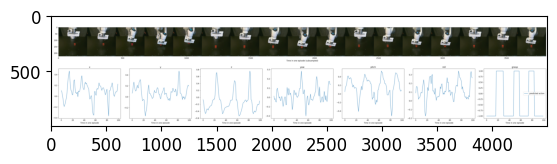

In [7]:
import io
from PIL import Image as PILImage

def plot_trajectory(pred_actions, true_actions=None, imgs=None):
    # expecting imgs T, N, C, H, W where N is the number of images

    # https://github.com/octo-models/octo/blob/main/examples/01_inference_pretrained.ipynb
    ACTION_DIM_LABELS = ["x", "y", "z", "yaw", "pitch", "roll", "grasp"]
    if pred_actions.shape[-1] == 4:
        ACTION_DIM_LABELS = ["x", "y", "z", "grasp"]

    # build image strip to show above actions
    if imgs is not None:
        img_strip = np.concatenate(imgs.squeeze()[::6].transpose(0, 2, 3, 1), axis=1)

    # set up plt figure
    figure_layout = [["image"] * len(ACTION_DIM_LABELS), ACTION_DIM_LABELS]
    plt.rcParams.update({"font.size": 12})
    fig, axs = plt.subplot_mosaic(figure_layout)
    fig.set_size_inches([45, 10])

    # plot actions
    pred_actions = np.array(pred_actions).squeeze()
    if true_actions is not None:
        true_actions = np.array(true_actions).squeeze()
    for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
        # actions have batch, horizon, dim, in this example we just take the first action for simplicity
        axs[action_label].plot(pred_actions[:, action_dim], label="predicted action")
        if true_actions is not None:
            axs[action_label].plot(true_actions[:, action_dim], label="ground truth")
        axs[action_label].set_title(action_label)
        axs[action_label].set_xlabel("Time in one episode")

    if imgs is not None:
        axs["image"].imshow(img_strip)
    axs["image"].set_xlabel("Time in one episode (subsampled)")
    plt.legend()
    plt.tight_layout()

    # figure to buffer to PIL to numpy
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    image = PILImage.open(buf)
    image_array = np.array(image)
    buf.close()
    plt.close(fig)

    return image_array

plot_img = plot_trajectory(
            pred_actions=actions[:100],
            true_actions=None,
            imgs=imgs.transpose(0, 3, 1, 2)[:100],
        )

plt.imshow(plot_img)

In [8]:
traj_lenghts = [len(f["data"][k]["actions"]) for k in demo_keys]
print("mean traj length", np.mean(traj_lenghts), "samples", traj_lenghts[:5], "...")

mean traj length 28.38 samples [30, 28, 26, 31, 27] ...


In [9]:
import imageio
from IPython.display import Video, display
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

imageio.mimwrite('tmp.mp4', imgs[:250])
display(Video('tmp.mp4'))

In [10]:
frm, to = 0, -1 # 65 + 69, -1

colors = []
for length in traj_lenghts:
    colors += list(range(0, length))
colors = np.array(colors)

# Sample 3D data
x, y, z = ee_pose[:, 0], ee_pose[:, 1], ee_pose[:, 2]

# Create a 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x[frm:to],
            y=y[frm:to],
            z=z[frm:to],
            mode="markers",
            marker=dict(
                size=5,
                color=colors,
                # color=actions[
                #     :, -1
                # ],
                opacity=0.8,
            ),
        )
    ]
)

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z",
        #        xaxis=dict(range=[ee_space_low[0], ee_space_high[0]]),
        # yaxis=dict(range=[ee_space_low[1], ee_space_high[1]]),
        # zaxis=dict(range=[ee_space_low[2], ee_space_high[2]])
        ),
    width=700,
    margin=dict(r=20, b=10, l=10, t=10),
)

fig.show()

In [11]:
# Sample 3D data
x, y, z = actions[:, 0], actions[:, 1], actions[:, 2] # ee_pose[:, 0], ee_pose[:, 1], ee_pose[:, 2]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               #colorscale='inferno',  # choose a colorscale
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [12]:
# Sample 3D data
def shortest_angle(angles):
    return (angles + np.pi) % (2*np.pi) - np.pi
actions[:, 3:6] = shortest_angle(actions[:, 3:6])

x, y, z = actions[:, 3], actions[:, 4], actions[:, 5] # ee_pose[:, 0], ee_pose[:, 1], ee_pose[:, 2]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               #colorscale='inferno',  # choose a colorscale
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [27]:
dataset_path_2nd = "/home/weirdlab/Projects/polymetis_franka/data/redcube_issac_1000_blocking_seed_10"
file_name = "demos.hdf5"
f = h5py.File(os.path.join(dataset_path_2nd, file_name),'r+')

demo_keys = list(f["data"].keys())
n_demos = 100
demo_keys = np.random.choice(demo_keys, n_demos, replace=True)

f["data"][demo_keys[0]].keys(), f["data"][demo_keys[0]]["obs"].keys()

(<KeysViewHDF5 ['actions', 'dones', 'obs']>,
 <KeysViewHDF5 ['front_rgb', 'language_instruction', 'lowdim_ee', 'lowdim_qpos', 'wrist_rgb']>)

In [28]:
traj_lenghts = [len(f["data"][k]["actions"]) for k in demo_keys]
print("mean traj length", np.mean(traj_lenghts), "samples", traj_lenghts[:5], "...")

mean traj length 27.44 samples [27, 28, 25, 26, 28] ...


In [29]:
# img_key = "215122255213_rgb"
img_key = "front_rgb"
# img_key = "agentview_image"

In [30]:
actions_2nd = np.concatenate([f["data"][k]["actions"] for k in demo_keys], axis=0)
ee_pose_2nd = np.concatenate([f["data"][k]["obs"]["lowdim_ee"] for k in demo_keys], axis=0)
imgs_2nd = np.concatenate([f["data"][k]["obs"][img_key] for k in demo_keys], axis=0)

actions_2nd.shape, ee_pose_2nd.shape, imgs_2nd.shape

((2744, 7), (2744, 7), (2744, 224, 224, 3))

In [31]:
import imageio
from IPython.display import Video, display
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

imageio.mimwrite('tmp_2nd.mp4', np.concatenate((imgs[:250], imgs_2nd[:250]), axis=2))
display(Video('tmp_2nd.mp4'))

In [36]:
xyz_min = ee_pose[...,:3].min(axis=0)
xyz_max = ee_pose[...,:3].max(axis=0)
plus_minus = np.abs((xyz_min - xyz_max) / 2)
xyz_min + plus_minus, plus_minus
# real ~ 0.5, 0.0 +/= 0.16

(array([0.45479544, 0.03771202, 0.23324278]),
 array([0.08726083, 0.10794207, 0.12029326]))

In [38]:
ee_pose[...,:3].min(axis=0), ee_pose[...,:3].max(axis=0)

(array([ 0.36753461, -0.07023005,  0.11294951]),
 array([0.54205626, 0.1456541 , 0.35353604]))

In [39]:
ee_pose_2nd[...,:3].min(axis=0), ee_pose_2nd[...,:3].max(axis=0)

(array([ 0.31231546, -0.11304978,  0.10887977]),
 array([0.50511217, 0.10269642, 0.31303203]))

In [33]:
xyz_min = ee_pose_2nd[...,:3].min(axis=0)
xyz_max = ee_pose_2nd[...,:3].max(axis=0)
plus_minus = np.abs((xyz_min - xyz_max) / 2)
xyz_min + plus_minus, plus_minus
# so, ~ 0.5, 0.0 +/= 0.16

(array([ 0.40871381, -0.00517668,  0.2109559 ]),
 array([0.09639835, 0.1078731 , 0.10207613]))

In [34]:
# Sample 3D data
x = np.concatenate([ee_pose[:, 0], ee_pose_2nd[:, 0]])
y = np.concatenate([ee_pose[:, 1], ee_pose_2nd[:, 1]])
z = np.concatenate([ee_pose[:, 2], ee_pose_2nd[:, 2]])
colors = np.zeros(len(x))
colors[len(ee_pose):] = 1

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               colorscale='viridis',
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [22]:
# RAW
x = np.concatenate([actions[:, 0], actions_2nd[:, 0]])
y = np.concatenate([actions[:, 1], actions_2nd[:, 1]])
z = np.concatenate([actions[:, 2], actions_2nd[:, 2]])
colors = np.zeros(len(x))
colors[len(ee_pose):] = 1

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               colorscale='viridis',
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [23]:
import pickle

# load stats
stats = pickle.load(open(os.path.join(dataset_path, "stats"), 'rb'))
stats_2nd = pickle.load(open(os.path.join(dataset_path_2nd, "stats"), 'rb'))

# unnormalize data
from openrt.scripts.convert_isaac_to_hdf5 import unnormalize

actions_unnorm = unnormalize(actions, stats["action"])
actions_unnorm_2nd = unnormalize(actions_2nd, stats_2nd["action"])

In [24]:
# UNNORMALIZED
x = np.concatenate([actions_unnorm[:, 0], actions_unnorm_2nd[:, 0]])
y = np.concatenate([actions_unnorm[:, 1], actions_unnorm_2nd[:, 1]])
z = np.concatenate([actions_unnorm[:, 2], actions_unnorm_2nd[:, 2]])
colors = np.zeros(len(x))
colors[len(ee_pose):] = 1

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               colorscale='viridis',
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [25]:
actions_norm = unnormalize(actions_unnorm, stats["action"])
actions_norm_2nd = unnormalize(actions_unnorm_2nd, stats["action"])

In [26]:
# NORMALIZED W/ REAL STATS
x = np.concatenate([actions_norm[:, 0], actions_norm_2nd[:, 0]])
y = np.concatenate([actions_norm[:, 1], actions_norm_2nd[:, 1]])
z = np.concatenate([actions_norm[:, 2], actions_norm_2nd[:, 2]])
colors = np.zeros(len(x))
colors[len(ee_pose):] = 1

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               colorscale='viridis',
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [ ]:
"real", actions_unnorm[...,:3].min(axis=0), actions_unnorm[...,:3].max(axis=0), \
    "sim", actions_unnorm_2nd[...,:3].min(axis=0), actions_unnorm_2nd[...,:3].max(axis=0)

('real',
 array([-0.01358601, -0.0052869 , -0.01934447]),
 array([0.01323208, 0.00887447, 0.01140563]),
 'sim',
 array([-0.0157866 , -0.00963558, -0.01503054]),
 array([0.013425  , 0.01086074, 0.02339736]))

In [ ]:
"real", actions_unnorm.min(axis=0), actions_unnorm.max(axis=0), \
    "sim", actions_unnorm_2nd.min(axis=0), actions_unnorm_2nd.max(axis=0)

('real',
 array([-0.01358601, -0.0052869 , -0.01934447, -0.02003438, -0.05838773,
        -0.03313636,  0.        ]),
 array([0.01323208, 0.00887447, 0.01140563, 0.02079986, 0.03692099,
        0.04921368, 1.        ]),
 'sim',
 array([-0.0157866 , -0.00963558, -0.01503054, -0.03192781, -0.04399485,
        -0.07063103,  0.        ]),
 array([0.013425  , 0.01086074, 0.02339736, 0.04097651, 0.06248594,
        0.03510947, 1.        ]))

In [ ]:
"real", ee_pose.min(axis=0), ee_pose.max(axis=0), \
    "sim", ee_pose_2nd.min(axis=0), ee_pose_2nd.max(axis=0)

('real',
 array([ 0.41020618, -0.01661774,  0.13338149, -3.14140659, -0.01713667,
        -0.32526624,  0.03856947]),
 array([0.53788418, 0.06627927, 0.3143415 , 3.14155653, 0.15703656,
        0.72612351, 0.08000064]),
 'sim',
 array([ 0.33264761, -0.14375301,  0.11301426, -3.1414613 , -0.02542021,
        -0.75745037,  0.03731762]),
 array([0.61401532, 0.16698069, 0.32097557, 3.1415837 , 0.50124174,
        0.76970285, 0.08174708]))

In [ ]:
"real", actions_unnorm.min(axis=0), actions_unnorm.max(axis=0), \
    "sim", actions_unnorm_2nd.min(axis=0), actions_unnorm_2nd.max(axis=0)

('real',
 array([-0.01358601, -0.0052869 , -0.01934447, -0.02003438, -0.05838773,
        -0.03313636,  0.        ]),
 array([0.01323208, 0.00887447, 0.01140563, 0.02079986, 0.03692099,
        0.04921368, 1.        ]),
 'sim',
 array([-0.0157866 , -0.00963558, -0.01503054, -0.03192781, -0.04399485,
        -0.07063103,  0.        ]),
 array([0.013425  , 0.01086074, 0.02339736, 0.04097651, 0.06248594,
        0.03510947, 1.        ]))

In [ ]:
# Sample 3D data
x = np.concatenate([actions[:, 0], actions_2nd[:, 0]])
y = np.concatenate([actions[:, 1], actions_2nd[:, 1]])
z = np.concatenate([actions[:, 2], actions_2nd[:, 2]])
colors = np.zeros(len(x))
colors[len(ee_pose):] = 1

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               colorscale='viridis',
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [ ]:
# Sample 3D data
def shortest_angle(angles):
    return (angles + np.pi) % (2*np.pi) - np.pi
actions_2nd[:, 3:6] = shortest_angle(actions_2nd[:, 3:6])

x = np.concatenate([actions[:, 3], actions_2nd[:, 3]])
y = np.concatenate([actions[:, 4], actions_2nd[:, 4]])
z = np.concatenate([actions[:, 5], actions_2nd[:, 5]])
colors = np.zeros(len(x))
colors[len(ee_pose):] = 1

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=5,
                                               color=colors, # actions[:,-1], # z,  # set color to an array/list of desired values
                                               colorscale='viridis',
                                               opacity=0.8))])

# Make the plot interactive by allowing user to rotate, zoom, etc.
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()
